In [1]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pillow 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import tensorflow as tf

from PIL import UnidentifiedImageError

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)

# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)

# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# for plotting
import numpy as np
import matplotlib.pyplot as plt

2024-04-10 20:20:09.389502: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:20:09.393931: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:20:09.456957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 20:20:10.357675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
def plot_history(H, epochs, save_path):
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()

    # Save plot
    plt.savefig(save_path)

    # Show plot
    plt.show()


In [8]:
import os

folder_path = os.path.join("..",
                        "..",
                        "..",
                        "..",
                        "..",
                        "cds-vis-data",
                        "Tobacco3482")

# Initialize empty lists
list_of_images = [] 
list_of_labels = []



for subfolder in sorted(os.listdir(folder_path)):
                
        # Extract images from the individual folders
        subfolder_path  = os.path.join(folder_path, subfolder)
                
        for file in os.listdir(subfolder_path):
                        
                individual_filepath = os.path.join(subfolder_path, file)
                        
                try:
                        # Load image from file
                        image = load_img(individual_filepath, target_size = (224, 224))
                        list_of_images.append(image)

                        # Extract image name and append to list
                        #image_name = individual_filepath.split("/")[-1]
                        #list_of_images.append(image_name)

                        # Extract label and append to list
                        label = subfolder_path.split("/")[-1]
                        list_of_labels.append(label)
                
                except (UnidentifiedImageError):
                        print(f"Skipping {individual_filepath}")

        

array_of_images = np.array(list_of_images)

# prepare the images for the VGG model
X= preprocess_input(array_of_images)
y= list_of_labels
        

Skipping ../../../../../cds-vis-data/Tobacco3482/ADVE/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Email/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Form/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Letter/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Memo/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/News/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Note/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Report/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Resume/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Scientific/Thumbs.db


In [10]:
#make test/train split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify= y, random_state=123)

#normalize
X_train= X_train.astype("float32")/255.
X_test= X_test.astype("float32")/255.


# integers to one-hot vectors
lb= LabelBinarizer()
y_train= lb.fit_transform(y_train) #shape 2785,10
y_test= lb.fit_transform(y_test) #shape 697,10

In [11]:
#load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(224, 224, 3)) #shape of our pictures

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
#adding new classifier layers (clean model with no batch normalization)
flat1 = Flatten()(model.layers[-1].output)  # take final layer (-1) in the model and append to flat1
class1 = Dense(128, activation = 'relu')(flat1)
output = Dense(10, activation = 'softmax')(class1)

# define new model
model = Model(inputs = model.inputs, 
              outputs = output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 10000,
    decay_rate = 0.9)
    
sgd = SGD(learning_rate=lr_schedule)
#adam = Adam(learning_rate=lr_schedule)

model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# summarize
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,642 (56.39 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
#train the model 
H = model.fit(X_train, y_train, 
            validation_split=0.1,
            batch_size=128,
            epochs=10,
            verbose=1)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.1654 - loss: 2.3152 - val_accuracy: 0.3262 - val_loss: 2.1571
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.2633 - loss: 2.1346 - val_accuracy: 0.3118 - val_loss: 2.1206
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.2986 - loss: 2.1088 - val_accuracy: 0.3584 - val_loss: 2.0950
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.3139 - loss: 2.0743 - val_accuracy: 0.3728 - val_loss: 2.0649
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.3128 - loss: 2.0568 - val_accuracy: 0.3620 - val_loss: 2.0382
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.3325 - loss: 2.0279 - val_accuracy: 0.3871 - val_loss: 2.0090
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.3429 - loss: 1.9826 - val_accuracy: 0.4229 - val_loss: 1.9843
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.3448 - loss: 1.9605 - val_accuracy: 0.4265 - v

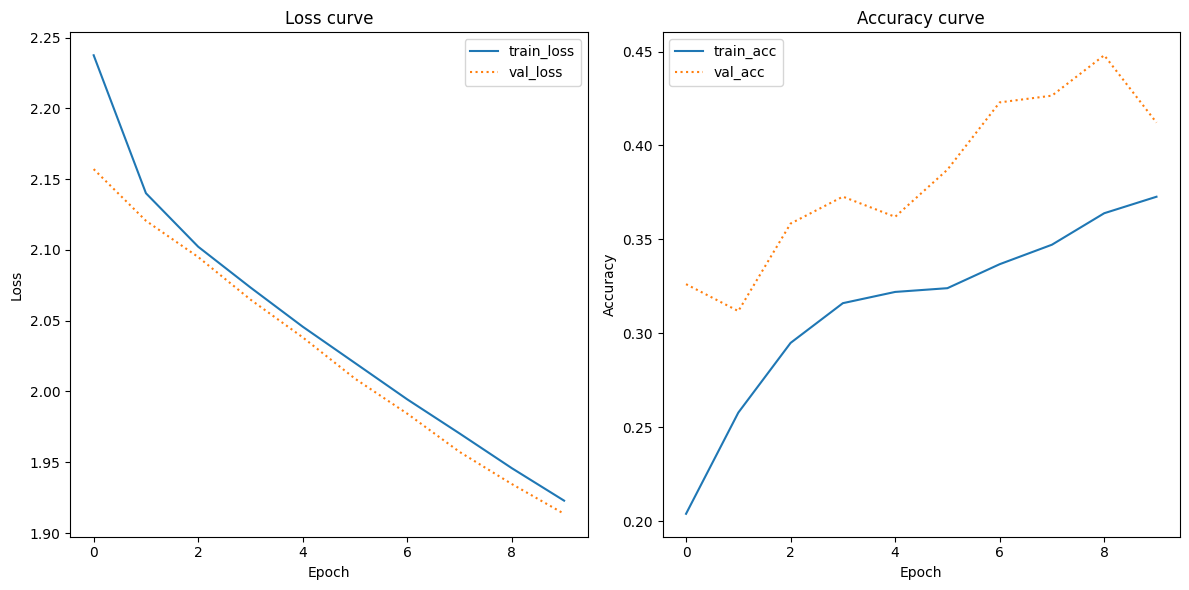

In [19]:
plot_history(H, 10, "../out/VGG16_losscurve_no_batch_normalization_sgd.png")

In [21]:
label_names = ["ADVE", "Email", "Form", "Letter", "Memo", "News", "Note", "Report", "Resume", "Scientific"]

predictions = model.predict(X_test, batch_size=128)
classifier_metrics = (classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=label_names))

print(classifier_metrics)


filepath_metrics = open('../out/VGG16_metrics_no_batch_normalization_sgd.txt', 'w')
filepath_metrics.write(classifier_metrics)
filepath_metrics.close()

6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step
              precision    recall  f1-score   support

        ADVE       1.00      0.04      0.08        46
       Email       0.54      0.86      0.67       120
        Form       0.78      0.21      0.33        86
      Letter       0.27      0.93      0.42       114
        Memo       0.26      0.19      0.21       124
        News       0.00      0.00      0.00        38
        Note       0.00      0.00      0.00        40
      Report       0.00      0.00      0.00        53
      Resume       0.00      0.00      0.00        24
  Scientific       0.00      0.00      0.00        52

    accuracy                           0.36       697
   macro avg       0.29      0.22      0.17       697
weighted avg       0.35      0.36      0.27       697



/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
#reload model
del model
tf.keras.backend.clear_session()

In [23]:
#load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(224, 224, 3)) #shape of our pictures

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

#adding new classifier layers (clean model with no batch normalization)
flat1 = Flatten()(model.layers[-1].output)  # take final layer (-1) in the model and append to flat1
class1 = Dense(128, activation = 'relu')(flat1)
output = Dense(10, activation = 'softmax')(class1)

# define new model
model = Model(inputs = model.inputs, 
              outputs = output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 10000,
    decay_rate = 0.9)
    
#sgd = SGD(learning_rate=lr_schedule)
adam = Adam(learning_rate=lr_schedule)

model.compile(optimizer = adam,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# summarize
model.summary()

#train the model 
H = model.fit(X_train, y_train, 
            validation_split=0.1,
            batch_size=128,
            epochs=10,
            verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,642 (56.39 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.2706 - loss: 2.0925 - val_accuracy: 0.4767 - val_loss: 1.4702
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.5280 - loss: 1.3618 - val_accuracy: 0.5842 - val_loss: 1.2862
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.6160 - loss: 1.1798 - val_accuracy: 0.6237 - val_loss: 1.1955
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.6288 - loss: 1.1141 - val_accuracy: 0.6165 - val_loss: 1.1035
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.6673 - loss: 0.9923 - val_accuracy: 0.6667 - val_loss: 1.0321
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.7014 - loss: 0.9202 - val_accuracy: 0.6738 - val_loss: 1.0164
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.7186 - loss: 0.8726 - val_accuracy: 0.6667 - val_loss: 0.9381
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.7185 - loss: 0.8191 - val_accuracy: 0.7061 - v

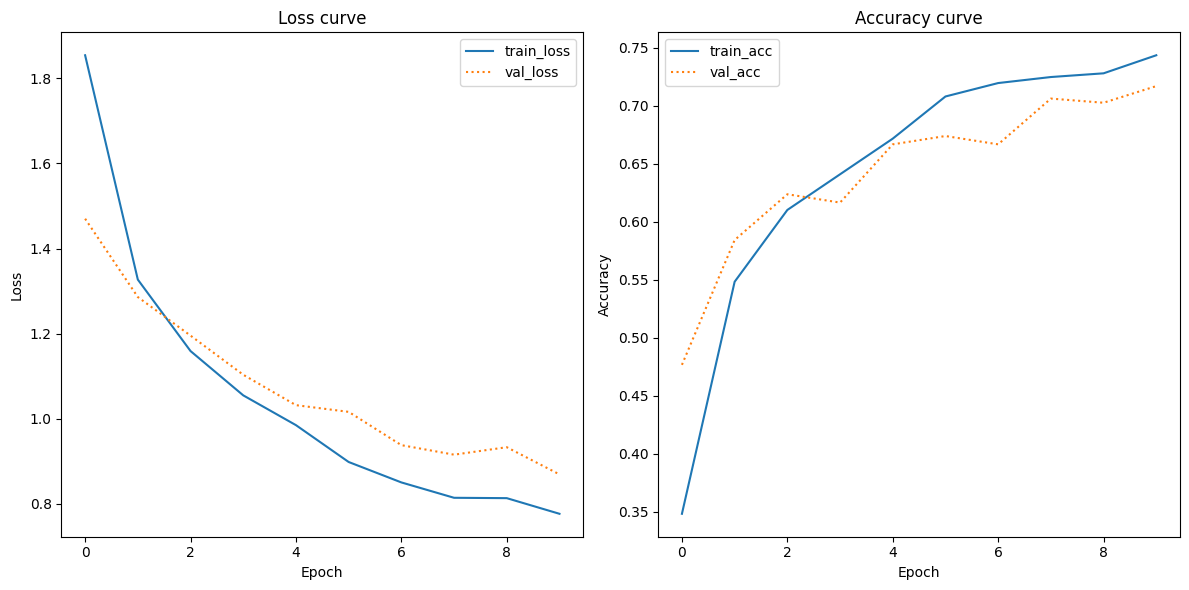

In [25]:
plot_history(H, 10, "../out/VGG16_losscurve_no_batch_normalization_adam.png")

In [27]:
label_names = ["ADVE", "Email", "Form", "Letter", "Memo", "News", "Note", "Report", "Resume", "Scientific"]

predictions = model.predict(X_test, batch_size=128)
classifier_metrics = (classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=label_names))

print(classifier_metrics)


filepath_metrics = open('../out/VGG16_metrics_no_batch_normalization_adam.txt', 'w')
filepath_metrics.write(classifier_metrics)
filepath_metrics.close()

6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step
              precision    recall  f1-score   support

        ADVE       0.79      0.89      0.84        46
       Email       0.92      0.90      0.91       120
        Form       0.68      0.84      0.75        86
      Letter       0.70      0.63      0.66       114
        Memo       0.60      0.79      0.69       124
        News       0.81      0.92      0.86        38
        Note       0.76      0.65      0.70        40
      Report       0.37      0.30      0.33        53
      Resume       0.54      0.54      0.54        24
  Scientific       0.77      0.19      0.31        52

    accuracy                           0.70       697
   macro avg       0.70      0.67      0.66       697
weighted avg       0.71      0.70      0.69       697

